# Part 3 - Model and results

## The Task
For this technical assessment, you have been tasked with identifying **characteristics that are
associated with a person making more or less than $50,000 per year**; the target variable for
your research question is the final column of the datasets.


As the data scientist on this project, you are to attempt to answer this question by constructing a
data analysis/modeling pipeline. Code submissions should be in Python and making the solution
easily readable and replicable by the team will give you additional marks. In the event you would
like to use a different language or tool, please ask. Considerations for your data analysis should
include, but are not limited to, the following:
- Data Preparation: Data cleaning, preprocessing, feature engineering, etc., that may aid
in improving data clarity & model generation.
- Exploratory Data Analysis: Numerical and/or graphical representations of the data that
may help inform insights and/or tactics for answering the research question of interest.
- **Data Modeling: The building of a few competing models to predict the target variable.**
- **Model Assessment: A selection of the best model based on performance comparisons.**
- **Results: A concise summary of key findings, recommendations, & future improvements.**

## Modelling objective
- To identify the characteristics that are **associated with a person making more or less than $50,000 per year**
- The target variable for your research question is the final column of the datasets (`target`)

#### What would be a good model
- To be able to classify whether a person earns more than 50,000 per year or not
- It is important to aware that only 6.2% of samples are earning more than 50,000. It would be important for balancing precision and recall
- We will test different fitting algorithms, including ensemble methods like random forest and boosting. Models that produce the best F-1 scored on test dataset will be selected.

#### Approach
1. Build the data transformation pipeline
    - Data casting
    - Normalisation of linear variables
2. Build train and validation dataset (Prepare for k-fold validation)
3. Model training
    - From the inspection of variables, I will be using a CART tree model to start with
    - This is because we have a lot of categorical variables, and also I assume the relationship will be non-linear
4. Use ensemble methods (Random forest, XGBoost) to improve accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib


In [2]:
# Load dataset (replace with your dataset)
data = pd.read_csv("./data/census_income_learn_processed.csv")
test_data = pd.read_csv("./data/census_income_test_processed.csv")

In [3]:
data.shape

(199523, 42)

In [4]:
test_data.shape

(99762, 42)

## 1. Build data transformation pipeline
Based on EDA, we will select the following features:
- Continuous variables candidates:
    - AAGE  (AGE)
    - NOEMP (Num persons worked for employer)
    - VETYN (Veterans benefits)
    - WKSWORK (weeks worked in year)
- Cateogorical variables candidates:
    - Using tree-based model can handle multicollinearity
    - Variables that indicate working:
        - ACLSWKR (Class of worker)
        - ADTIND (Industry Code)
        - ADTOCC (Occupation Code)
        - AWKSTAT (Full or part tiem employment stat)
        - FILESTAT (Tax file status)
    - Variables about family structure
        - HHDFMX (Detailed household and family stat)
        - HHDREL (Detailed household summary in household)
        - PARENT (Family members under 18)
    - AHGA (Education)
    - AMARITL (Marital Status)
    - ARACE (Race)
    - ASEX (Sex)

In [5]:
num_attribs = ["AAGE", "NOEMP", "VETYN", "WKSWORK"]
cat_attribs = ["ACLSWKR", "ADTIND", "ADTOCC", "AWKSTAT", "FILESTAT", "HHDFMX", "HHDREL", "PARENT",
               "AHGA", "AMARITL", "ARACE", "ASEX"]
label = "target"

In [45]:
# Split the data into features and labels
X = data.loc[:, num_attribs + cat_attribs]
y = data[label]

test_X = test_data.loc[:, num_attribs + cat_attribs]
test_y = test_data[label]

In [7]:
# Setup Data transformation pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore')) # Ignore unknown

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

## 2. Attach transformation pipeline with Model Training pipeline
- We will attach the `DecisionTreeClassifier` to the transformation pipeline
- By doing this, it is easier to manage the whole process and can facilitate model evaluation and selection

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [9]:
dstree = make_pipeline(preprocessing, DecisionTreeClassifier(max_depth=10, random_state=42))

In [10]:
fitted = dstree.fit(X, y)

In [11]:
dstree.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['AAGE', 'NOEMP', 'VETYN', 'WKSWORK']),
                                 ('cat',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AWKSTAT',
                                   'FILESTAT', 'HHDFMX', 'HHDREL', 'PARENT',
                                   'AHGA', 'AMARITL', 'ARACE', 'ASEX'])]),
 'decisiontreeclassifier': DecisionTreeClassifier(max_depth=10, random_state=42)}

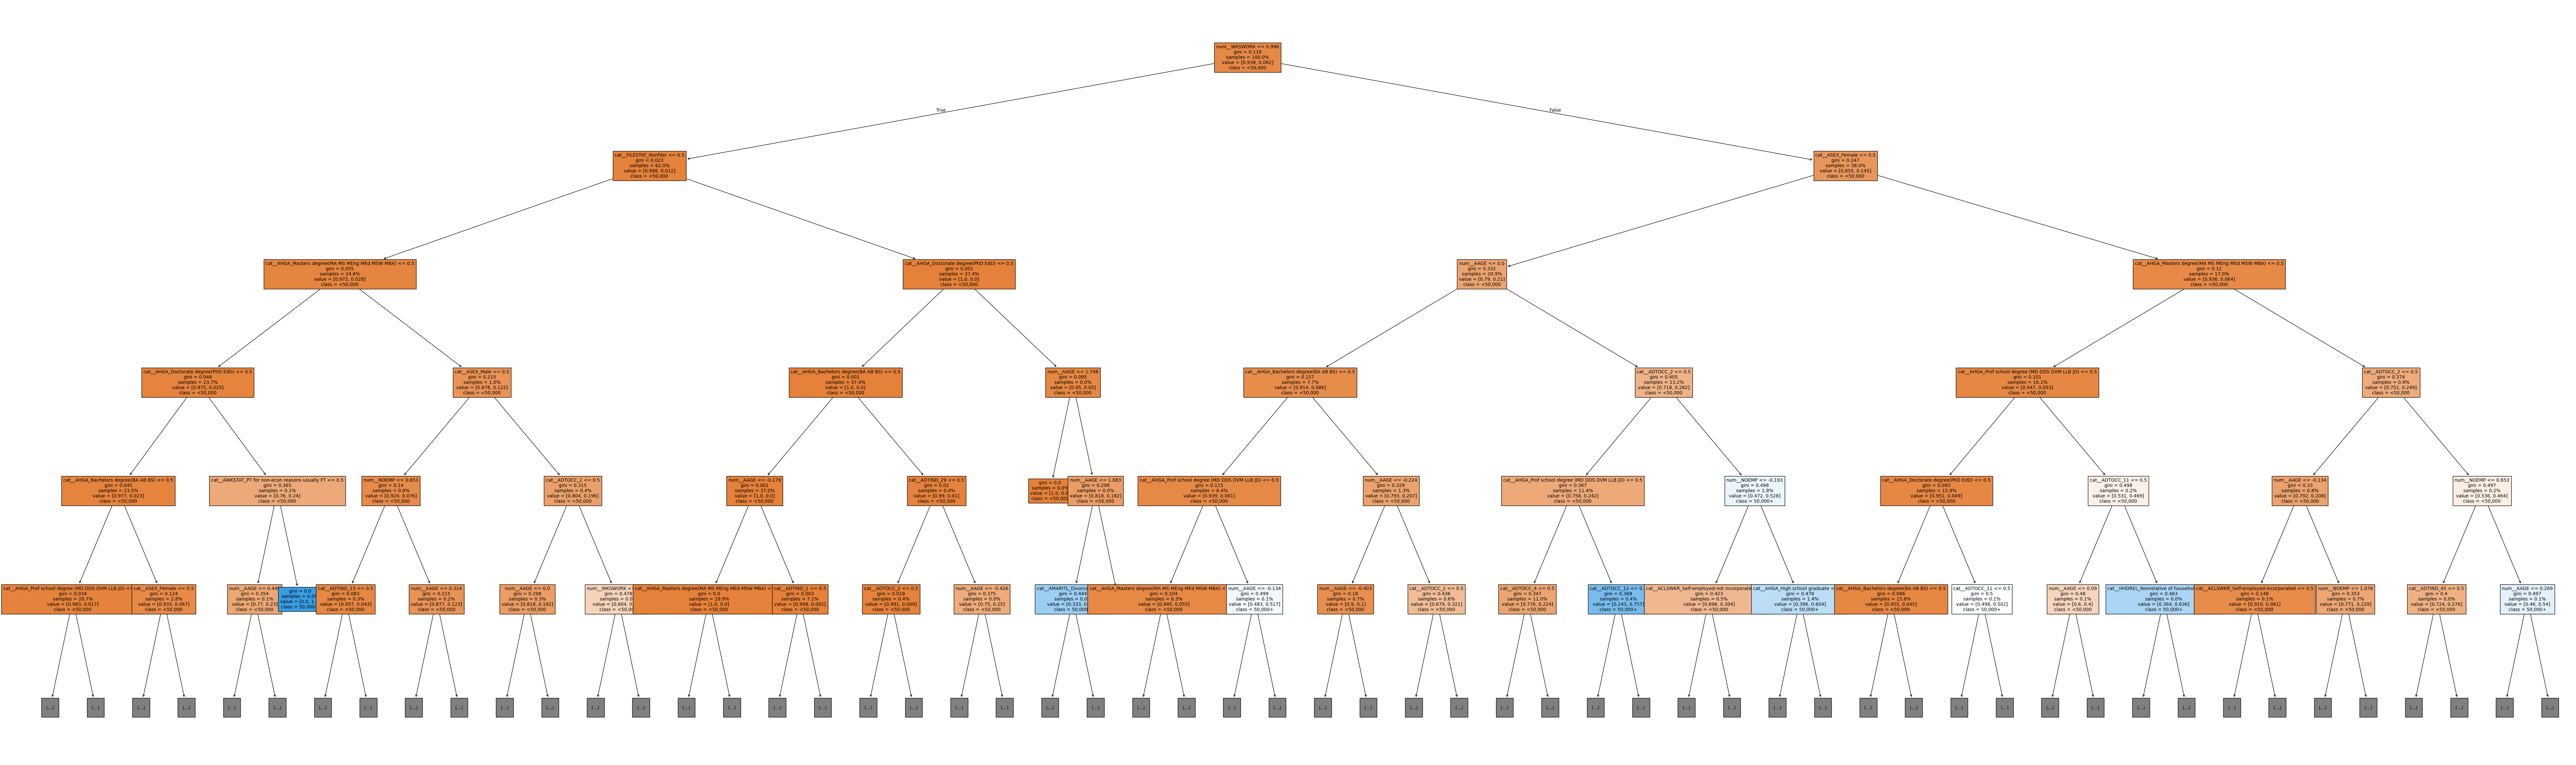

In [13]:
fig, ax = plt.subplots(figsize=(100, 30))

plot_tree(dstree['decisiontreeclassifier'], proportion=True,
          ax=ax,
          fontsize=10,
          feature_names=dstree["columntransformer"].get_feature_names_out(),
          class_names=["<50,000", "50,000+"],
          filled=True,
          max_depth=5)
# plt.show()
plt.savefig('tree_plot.png')

In [14]:
dstree.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['AAGE', 'NOEMP', 'VETYN', 'WKSWORK']),
                                 ('cat',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AWKSTAT',
                                   'FILESTAT', 'HHDFMX', 'HHDREL', 'PARENT',
                                   'AHGA', 'AMARITL', 'ARACE', 'ASEX'])]),
 'decisiontreeclassifier': DecisionTreeClassifier(max_depth=10, random_state=42)}

Text(0.5, 0, 'Gini Importance')

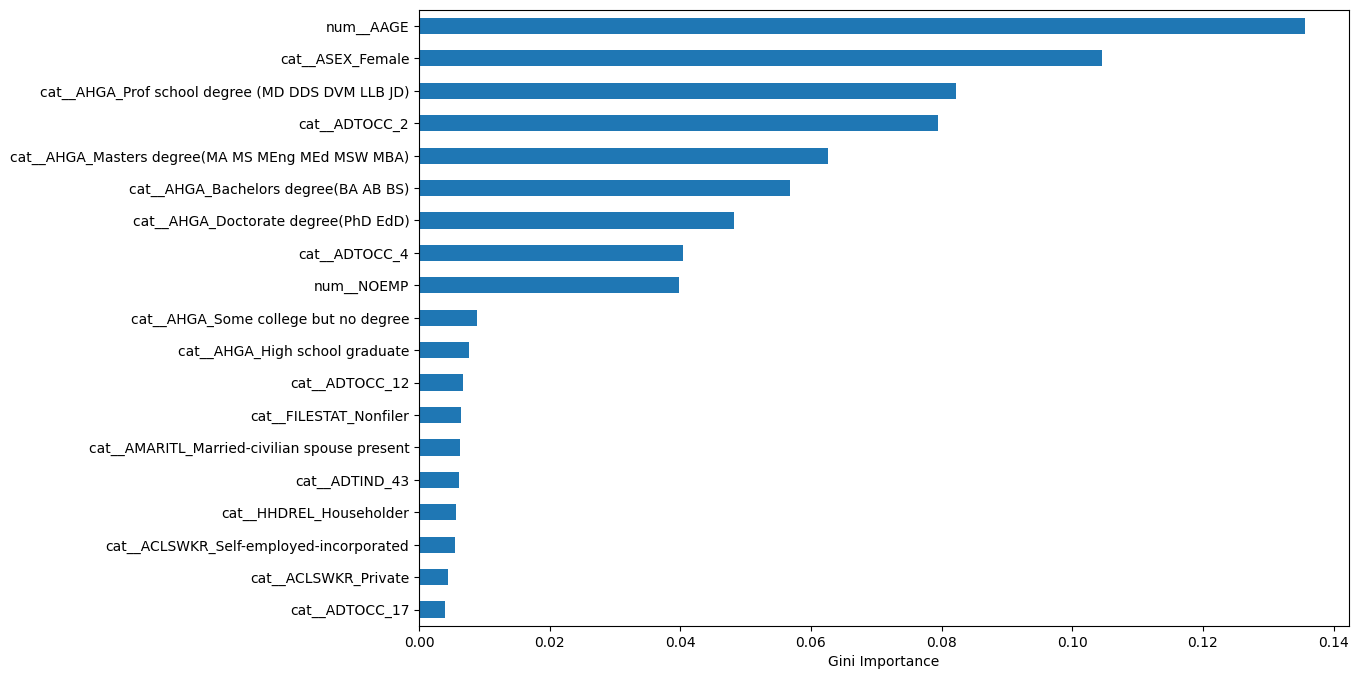

In [15]:
# Feature Importance
mdi_importances = pd.Series(dstree['decisiontreeclassifier'].feature_importances_,
                            index=dstree['columntransformer'].get_feature_names_out())
tree_importance_sorted_idx = np.argsort(dstree['decisiontreeclassifier'].feature_importances_)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mdi_importances.sort_values()[-20:-1].plot.barh(ax=ax)
ax.set_xlabel("Gini Importance")

In [24]:
joblib.dump(dstree, "cart_tree.joblib")

['cart_tree.joblib']

## 3. Use cross validation to evaluate the model performance

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

In [26]:
precision_scorer = make_scorer(precision_score, pos_label="50000+.")
recall_scorer    = make_scorer(recall_score, pos_label="50000+.")
f1_scorer        = make_scorer(f1_score, pos_label="50000+.")

tree_precision = cross_val_score(dstree, X, y,scoring=precision_scorer, cv=10)
tree_recall    = cross_val_score(dstree, X, y,scoring=recall_scorer, cv=10)
tree_f1        = cross_val_score(dstree, X, y,scoring=f1_scorer, cv=10)

In [27]:
pd.Series(tree_precision).describe()

count    10.000000
mean      0.619909
std       0.019427
min       0.596519
25%       0.609208
50%       0.614374
75%       0.633303
max       0.658015
dtype: float64

In [28]:
pd.Series(tree_recall).describe()

count    10.000000
mean      0.311661
std       0.015663
min       0.296446
25%       0.302645
50%       0.306139
75%       0.312197
max       0.348142
dtype: float64

In [29]:
pd.Series(tree_f1).describe()

count    10.000000
mean      0.414639
std       0.016528
min       0.399565
25%       0.403835
50%       0.409898
75%       0.417501
max       0.455362
dtype: float64

In [30]:
# Performance on Test dataset
test_precision = precision_scorer(dstree, test_X, test_y)
test_recall = recall_scorer(dstree, test_X, test_y)
test_f1 = f1_scorer(dstree, test_X, test_y)

In [31]:
print("Test Precision: %.2f, Test recall: %.2f, Test F1: %.2f" % (test_precision, test_recall, test_f1))

Test Precision: 0.64, Test recall: 0.32, Test F1: 0.43


## 4. Ensemble methods to improve performance
- Performance based on F1 score
- Use Random Forest and XGBoost as ensemble methods
- Run grid search on hyperparameter search
- Baseline score on test (10-level decision tree, threshold = 0.5)
    - Precision: 0.64
    - Recall: 0.32
    - F1: 0.43

In [32]:
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [67]:
rf_clf = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))
xgb_clf = make_pipeline(preprocessing, xgb.XGBClassifier(random_state=42))

In [68]:
rf_clf.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['AAGE', 'NOEMP', 'VETYN', 'WKSWORK']),
                                 ('cat',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AWKSTAT',
                                   'FILESTAT', 'HHDFMX', 'HHDREL', 'PARENT',
                                   'AHGA', 'AMARITL', 'ARACE', 'ASEX'])]),
 'randomforestclassifier': RandomForestClassifier(random_state=42)}

In [70]:
# Random Forest Grid Search
param_grid = [
    {
        'randomforestclassifier__n_estimators': [100, 200],
        'randomforestclassifier__max_depth': [None, 20, 30],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 5],
        'randomforestclassifier__bootstrap': [True, False],
    }
]

grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring=f1_scorer,
                           verbose=3, n_jobs=4)
grid_search.fit(X, y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 3/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.435 total time=  58.0s
[CV 2/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.431 total time= 2.0min


/Users/raylai/Desktop/env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0.431 total time=  58.5s
[CV 3/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.432 total time= 2.0min
[CV 3/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200;, score=0.437 total time= 1.2min
[CV 1/3] END randomforestclassifier__bootstrap=True, randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100;, score=0

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['AAGE',
                                                                          'NOEMP',
                                                                          'VETYN',
                                                                          'WKSWORK']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ACLSWKR',
                                                                          'ADTIND',
                                                                          'ADTOCC',
                                                                          'AWKSTAT',
                                                                          'FILESTAT',
                                                                          'HHDFMX',
                                                                          'HHDREL',
                                                                          'PAREN...
             param_grid=[{'randomforestclassifier__bootstrap': [True, False],
                          'randomforestclassifier__max_depth': [None, 20, 30],
                          'randomforestclassifier__min_samples_leaf': [1, 2, 5],
                          'randomforestclassifier__min_samples_split': [2, 5,
                                                                        10],
                          'randomforestclassifier__n_estimators': [100, 200]}],
             scoring=make_scorer(f1_score, response_method='predict', pos_label=50000+.),
             verbose=3)

In [73]:
rf_best = grid_search.best_estimator_
joblib.dump(rf_best, "rf_best.joblib")

['rf_best.joblib']

In [74]:
gcv_results = pd.DataFrame(grid_search.cv_results_)
gcv_results.to_csv("rf_gcv_results.csv")

In [75]:
gcv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__bootstrap,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,57.451389,0.332243,0.991590,0.011720,True,None,1,2,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.452935,0.430614,0.435303,0.439617,0.009609,8
1,115.941170,0.380234,1.662251,0.035000,True,None,1,2,200,"{'randomforestclassifier__bootstrap': True, 'r...",0.450223,0.431465,0.432466,0.438051,0.008616,10
2,37.741311,0.565306,0.927891,0.027689,True,None,1,5,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.452373,0.429114,0.439974,0.440487,0.009503,6
3,73.311301,0.425782,1.565466,0.020967,True,None,1,5,200,"{'randomforestclassifier__bootstrap': True, 'r...",0.451988,0.427488,0.436505,0.438661,0.010117,9
4,30.518191,0.432347,0.881904,0.010164,True,None,1,10,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.448737,0.422207,0.432846,0.434597,0.010901,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,55.618286,2.109153,1.477189,0.023673,False,30,5,2,200,"{'randomforestclassifier__bootstrap': False, '...",0.391641,0.375978,0.381974,0.383198,0.006453,55
104,27.429765,0.466801,0.884152,0.020265,False,30,5,5,100,"{'randomforestclassifier__bootstrap': False, '...",0.391281,0.375045,0.379828,0.382052,0.006812,58
105,55.456721,0.712625,1.476372,0.021281,False,30,5,5,200,"{'randomforestclassifier__bootstrap': False, '...",0.391641,0.375978,0.381974,0.383198,0.006453,55
106,27.730077,0.670136,0.878653,0.015391,False,30,5,10,100,"{'randomforestclassifier__bootstrap': False, '...",0.391281,0.375045,0.379828,0.382052,0.006812,58


In [77]:
xgb_clf.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  ['AAGE', 'NOEMP', 'VETYN', 'WKSWORK']),
                                 ('cat',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['ACLSWKR', 'ADTIND', 'ADTOCC', 'AWKSTAT',
                                   'FILESTAT', 'HHDFMX', 'HHDREL', 'PARENT',
                                   'AHGA', 'AMARITL', 'ARACE', 'ASEX'])]),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_type

In [81]:
f1_scorer

make_scorer(f1_score, response_method='predict', pos_label=50000+.)

In [85]:
y.value_counts()

target
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

In [88]:
y = y.apply(lambda x: 0 if x == "- 50000." else 1)

In [91]:
# Random Forest Grid Search
param_grid = [{
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__min_child_weight': [1, 3, 5],
    'xgbclassifier__gamma': [0, 0.1, 0.2],
    'xgbclassifier__reg_lambda': [1, 10] # Seeking for sparsity
}]

grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="f1",
                           verbose=3, n_jobs=4)
grid_search.fit(X, y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV 1/3] END xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=100, xgbclassifier__reg_lambda=1;, score=0.000 total time=   1.1s
[CV 2/3] END xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=100, xgbclassifier__reg_lambda=10;, score=0.000 total time=   0.8s
[CV 3/3] END xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=200, xgbclassifier__reg_lambda=1;, score=0.000 total time=   1.2s
[CV 1/3] END xgbclassifier__gamma=0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3, xgbclassifier__n_estimators=100, xgbclassifier__reg_lambda=1;, score=0.000 total time=   0.8s
[CV 2/3] END xgbclas

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['AAGE',
                                                                          'NOEMP',
                                                                          'VETYN',
                                                                          'WKSWORK']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ACLSWKR',
                                                                          'ADTIND',
                                                                          'ADTOCC',
                                                                          'AWKSTAT',
                                                                          'FILESTAT',
                                                                          'HHDFMX',
                                                                          'HHDREL',
                                                                          'PAREN...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=4,
             param_grid=[{'xgbclassifier__gamma': [0, 0.1, 0.2],
                          'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                          'xgbclassifier__max_depth': [3, 5, 7],
                          'xgbclassifier__min_child_weight': [1, 3, 5],
                          'xgbclassifier__n_estimators': [100, 200],
                          'xgbclassifier__reg_lambda': [1, 10]}],
             scoring='f1', verbose=3)

In [92]:
xgb_best = grid_search.best_estimator_
joblib.dump(xgb_best, "xgb_best.joblib")

['xgb_best.joblib']

In [93]:
gcv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__bootstrap,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,57.451389,0.332243,0.991590,0.011720,True,None,1,2,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.452935,0.430614,0.435303,0.439617,0.009609,8
1,115.941170,0.380234,1.662251,0.035000,True,None,1,2,200,"{'randomforestclassifier__bootstrap': True, 'r...",0.450223,0.431465,0.432466,0.438051,0.008616,10
2,37.741311,0.565306,0.927891,0.027689,True,None,1,5,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.452373,0.429114,0.439974,0.440487,0.009503,6
3,73.311301,0.425782,1.565466,0.020967,True,None,1,5,200,"{'randomforestclassifier__bootstrap': True, 'r...",0.451988,0.427488,0.436505,0.438661,0.010117,9
4,30.518191,0.432347,0.881904,0.010164,True,None,1,10,100,"{'randomforestclassifier__bootstrap': True, 'r...",0.448737,0.422207,0.432846,0.434597,0.010901,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,55.618286,2.109153,1.477189,0.023673,False,30,5,2,200,"{'randomforestclassifier__bootstrap': False, '...",0.391641,0.375978,0.381974,0.383198,0.006453,55
104,27.429765,0.466801,0.884152,0.020265,False,30,5,5,100,"{'randomforestclassifier__bootstrap': False, '...",0.391281,0.375045,0.379828,0.382052,0.006812,58
105,55.456721,0.712625,1.476372,0.021281,False,30,5,5,200,"{'randomforestclassifier__bootstrap': False, '...",0.391641,0.375978,0.381974,0.383198,0.006453,55
106,27.730077,0.670136,0.878653,0.015391,False,30,5,10,100,"{'randomforestclassifier__bootstrap': False, '...",0.391281,0.375045,0.379828,0.382052,0.006812,58


In [119]:
gcv_results = pd.DataFrame(grid_search.cv_results_)
gcv_results.to_csv("xgb_gcv_results.csv")

## 5. Check and compare model performance

In [33]:
# Baseline
float(pd.Series(tree_f1).describe()["mean"])

0.4146385474790201

In [35]:
rf_result = pd.read_csv("./export/rf_gcv_results.csv")
xgb_result = pd.read_csv("./export/xgb_gcv_results.csv")

In [36]:
float(rf_result.loc[rf_result.rank_test_score == 1, "mean_test_score"].values[0])

0.4440112812764392

In [37]:
float(xgb_result.loc[xgb_result.rank_test_score == 1, "mean_test_score"].values[0])

0.4844864011577546

In [142]:
print("Baseline F1: %.2f, Random Forest best F1: %.2f, XGboost best F1: %.2f" % (
    float(pd.Series(tree_f1).describe()["mean"]),
    float(rf_result.loc[rf_result.rank_test_score == 1, "mean_test_score"].values[0]),
    float(xgb_result.loc[xgb_result.rank_test_score == 1, "mean_test_score"].values[0])
))

Baseline F1: 0.41, Random Forest best F1: 0.44, XGboost best F1: 0.48


In [41]:
cart_model = joblib.load("./export/cart_tree.joblib")
rf_model = joblib.load("./export/rf_best.joblib")
xgb_model = joblib.load("./export/xgb_best.joblib")

In [ ]:
rf_mdi_importances = pd.Series(rf_model['randomforestclassifier'].feature_importances_,
                            index=dstree['columntransformer'].get_feature_names_out())

xgb_mdi_importances = pd.Series(xgb_model['xgbclassifier'].feature_importances_,
                            index=dstree['columntransformer'].get_feature_names_out())

cart_importances = pd.Series(dstree['decisiontreeclassifier'].feature_importances_,
                            index=dstree['columntransformer'].get_feature_names_out())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.set_title("Random Forest Feature Importances (Test F1 = 0.46)")
rf_mdi_importances.sort_values()[-20:-1].plot.barh(ax=ax1)
ax1.set_xlabel("Importance score")

ax2.set_title("XGBoost Feature Importances (Test F1 = 0.49)")
xgb_mdi_importances.sort_values()[-20:-1].plot.barh(ax=ax2)
ax2.set_xlabel("Importance score")

ax3.set_title("CART Tree Feature Importance (Test F1 = 0.43)")
cart_importances.sort_values()[-20:-1].plot.barh(ax=ax3)
ax3.set_xlabel("Gini Importance")

plt.tight_layout()

## 6. Best model testing performance

In [46]:
# Performance on Test dataset - Random Forest
precision_scorer = make_scorer(precision_score, pos_label="50000+.")
recall_scorer    = make_scorer(recall_score, pos_label="50000+.")
f1_scorer        = make_scorer(f1_score, pos_label="50000+.")

test_precision = precision_scorer(rf_model, test_X, test_y)
test_recall = recall_scorer(rf_model, test_X, test_y)
test_f1 = f1_scorer(rf_model, test_X, test_y)

In [47]:
print("Test Precision: %.2f, Test recall: %.2f, Test F1: %.2f" % (test_precision, test_recall, test_f1))

Test Precision: 0.63, Test recall: 0.36, Test F1: 0.46


In [48]:
test_y = test_y.apply(lambda x: 0 if x == "- 50000." else 1)

In [49]:
# Performance on Test dataset
precision_scorer = make_scorer(precision_score, pos_label=1)
recall_scorer    = make_scorer(recall_score, pos_label=1)
f1_scorer        = make_scorer(f1_score, pos_label=1)

test_precision = precision_scorer(xgb_model, test_X, test_y)
test_recall = recall_scorer(xgb_model, test_X, test_y)
test_f1 = f1_scorer(xgb_model, test_X, test_y)

In [50]:
print("Test Precision: %.2f, Test recall: %.2f, Test F1: %.2f" % (test_precision, test_recall, test_f1))

Test Precision: 0.69, Test recall: 0.38, Test F1: 0.49


In [177]:
from sklearn.metrics import PrecisionRecallDisplay

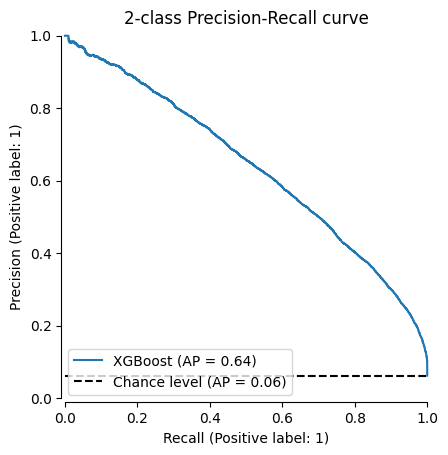

In [179]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_model, test_X, test_y, name="XGBoost", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Learnings
- We have built a model to predict the people in the US who are earning more than $50,000 per year
- The best model is an XGBoost model with Test Score: Precision: 0.73, Test recall: 0.41, Test F1: 0.52
    - It would be able to predict 73% correct out of all the positive predictions, which covers 41% of all positive samples
- Working related indicator clearly helps the prediction - Occupation Code (ADTOCC), Working Hours (WKSWORK), and NOEMP are ranked the most important attributes in both random forest model and XGBoost model
- Education serves as a good predictor too - AHGA (Education) is ranked important attributes across models
- In the model, especially in CART tree, gender and age also came up as important attributes. However, these are likely to be confounders as they could represent the working status and education of a person. This can be reserved for further study. 